# 해외 축구 선수 이적료 예측 미션

* 패키지 임포트

In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
# from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
from scipy.stats import skew
import scipy.stats as stats

from matplotlib import font_manager,rc # 한글 글꼴 사용
rc('font', family='AppleGothic') 

---

* 데이터 불러오기

In [2]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

* 전체 데이터 비율

In [3]:
print('train data ratio :',len(train)/(len(train)+len(test)))
print('test data ratio :',len(test)/(len(train)+len(test)))

train data ratio : 0.7
test data ratio : 0.3


* 데이터 확인

In [4]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [5]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


* 데이터 분포 확인

In [6]:
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [7]:
test.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,7846.258098,25.297806,1.143939,67.336991,72.107628,2.414838
std,4870.339361,4.628236,0.448465,6.908814,6.133428,0.781153
min,1.000000,16.000000,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,22.000000,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,25.000000,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,29.000000,1.000000,72.000000,76.000000,3.000000
max,16943.000000,42.000000,5.000000,94.000000,95.000000,5.000000


* 데이터 정보 확인

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


* 결측치 확인

In [10]:
train.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [11]:
test.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

* 중복값 확인

In [12]:
train[train.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value


In [13]:
test[test.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves


* 필요없는 변수 제거

In [14]:
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(['id','name'],axis=1,inplace=True)
test_copy.drop(['id','name'],axis=1,inplace=True)

* 학습데이터 변수 확인

In [15]:
train_copy['age'].unique()

array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
       18, 19, 37, 20, 39, 17, 38, 16])

In [16]:
train_copy['continent'].unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [17]:
train_copy['contract_until'].unique()
# 변수 확인 필요

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [18]:
train_copy['position'].unique()

array(['ST', 'GK', 'DF', 'MF'], dtype=object)

In [19]:
train_copy['prefer_foot'].unique()

array(['left', 'right'], dtype=object)

In [20]:
train_copy['reputation'].unique()

array([5., 4., 3., 1., 2.])

In [21]:
train_copy['stat_overall'].unique()

array([94, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
       75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
       58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [22]:
train_copy['stat_potential'].unique()

array([94, 93, 91, 90, 92, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,
       77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,
       60, 59, 58, 57, 56, 55, 54, 53, 52, 50, 48])

In [23]:
train_copy['stat_skill_moves'].unique()

array([4., 1., 3., 2., 5.])

* 테스트 데이터 변수 확인

In [24]:
test_copy['age'].unique()

array([33, 26, 27, 32, 29, 28, 24, 30, 19, 25, 31, 22, 23, 37, 35, 34, 36,
       21, 20, 40, 38, 18, 39, 17, 42, 16])

In [25]:
test_copy['continent'].unique()

array(['europe', 'south america', 'africa', 'asia', 'oceania'],
      dtype=object)

In [26]:
test_copy['contract_until'].unique()
# 변수 확인 필요

array(['2022', '2023', '2020', '2021', 'Jun 30, 2019', '2019', '2025',
       '2024', '2018', 'May 31, 2020', 'Jun 30, 2020', 'May 31, 2019',
       'Dec 31, 2019', 'Dec 31, 2018', 'Jun 1, 2019', 'Jan 1, 2019',
       'Jan 31, 2019', '2026'], dtype=object)

In [27]:
test_copy['position'].unique()

array(['ST', 'MF', 'DF', 'GK'], dtype=object)

In [28]:
test_copy['prefer_foot'].unique()

array(['right', 'left'], dtype=object)

In [29]:
test_copy['reputation'].unique()

array([5., 4., 3., 2., 1.])

In [30]:
test_copy['stat_overall'].unique()

array([94, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77,
       76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60,
       59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [31]:
test_copy['stat_potential'].unique()

array([94, 93, 92, 91, 90, 89, 95, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79,
       78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62,
       61, 60, 59, 58, 57, 56, 55, 54, 52])

In [32]:
test_copy['stat_skill_moves'].unique()

array([5., 4., 3., 2., 1.])

* contract_until 변수 확인

In [33]:
train_copy['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [34]:
test_copy['contract_until'].value_counts()

2021            985
2019            943
2020            882
2022            338
2023            251
Jun 30, 2019    209
2018            155
Dec 31, 2018     34
May 31, 2019     14
2025              4
Jun 30, 2020      4
2024              2
Jan 31, 2019      2
Jan 1, 2019       1
May 31, 2020      1
Jun 1, 2019       1
Dec 31, 2019      1
2026              1
Name: contract_until, dtype: int64

* contract_until 변수를 년도 4자리로만 표기

In [35]:
contract_train = []
contract_test = []
for i in train_copy['contract_until']:
    contract_train.append(i[-4:])
for i in test_copy['contract_until']:
    contract_test.append(i[-4:])

train_copy['contract_until'] = contract_train
test_copy['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train_copy['contract_until'] = train_copy['contract_until'].astype('int64')
test_copy['contract_until'] = test_copy['contract_until'].astype('int64')

In [36]:
train_copy['contract_until'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [37]:
test_copy['contract_until'].value_counts()

2019    1171
2021     985
2020     887
2022     338
2023     251
2018     189
2025       4
2024       2
2026       1
Name: contract_until, dtype: int64

* 학습용 데이터 변수의 시각화

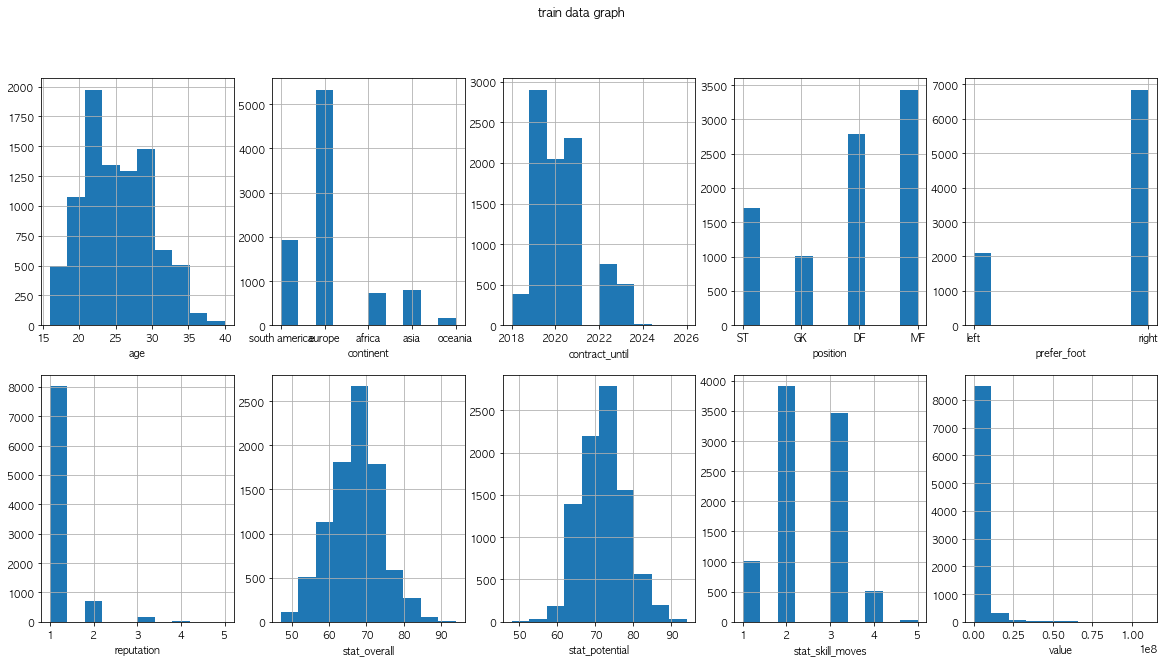

In [38]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    train_copy[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('train data graph')    
plt.show()

* 테스트 데이터 변수의 시각화

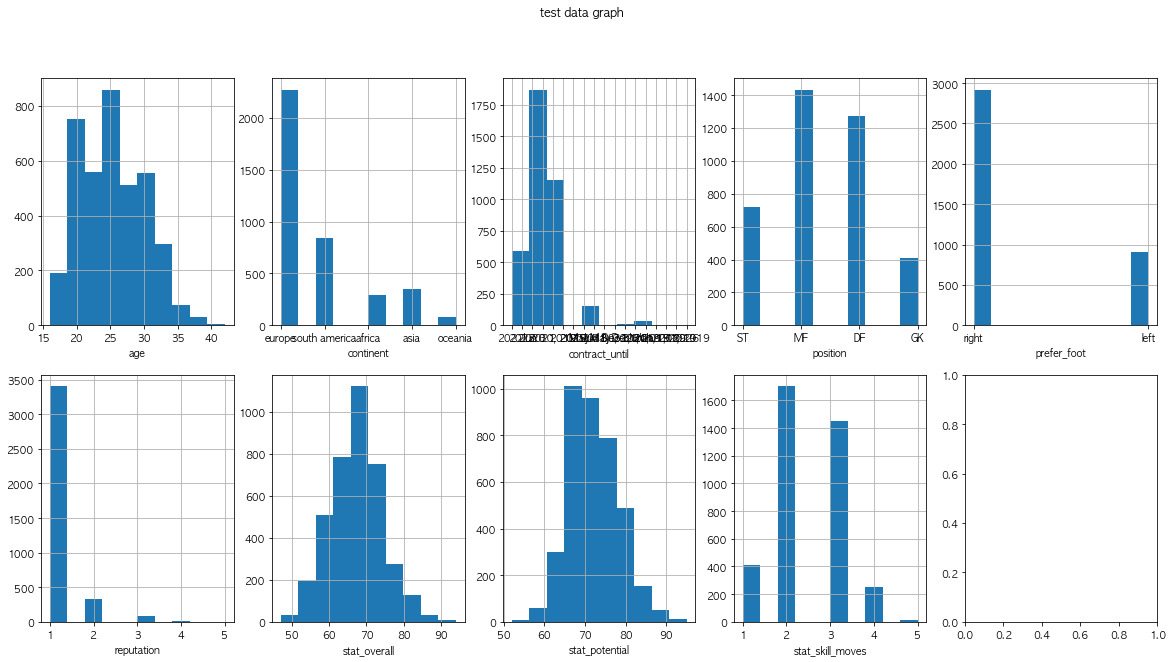

In [39]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = test_copy.columns
for i in range(len(test_copy.columns)):
    test[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('test data graph')    
plt.show()

* 학습용 데이터 value에 따른 그래프

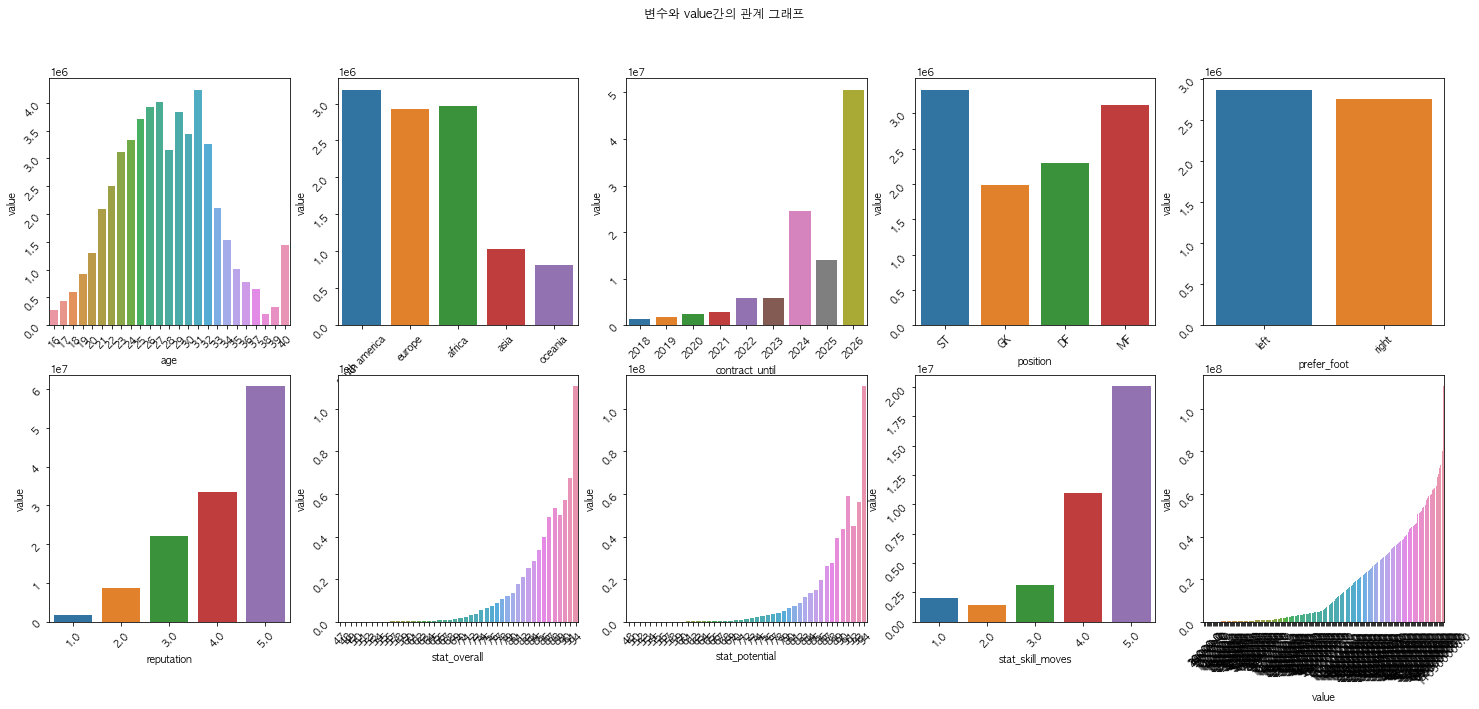

In [40]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.barplot(x=train_copy[col[i]],y=train_copy['value'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 value간의 관계 그래프')    
plt.show()


# sns.barplot(x=train['age'],y=train['value'],ci=0)
# plt.show()

In [41]:
# 대륙별 최고 몸값

DataFrame(train.groupby('continent')['value'].agg('max')).sort_values(by='value',ascending=False)

,value
continent,
south america,110500000.0
europe,73500000.0
africa,69500000.0
asia,14500000.0
oceania,10500000.0


* 40세에서 value가 높은 변수 확인

In [42]:
train[train['age']==40]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
23,41,G. Buffon,40,europe,2019,GK,right,4.0,88,88,1.0,4000000.0
1613,2735,S. Bertoli,40,south america,2019,GK,right,1.0,73,73,1.0,270000.0
5168,8995,B. Castillo,40,south america,2021,GK,right,1.0,66,66,1.0,40000.0


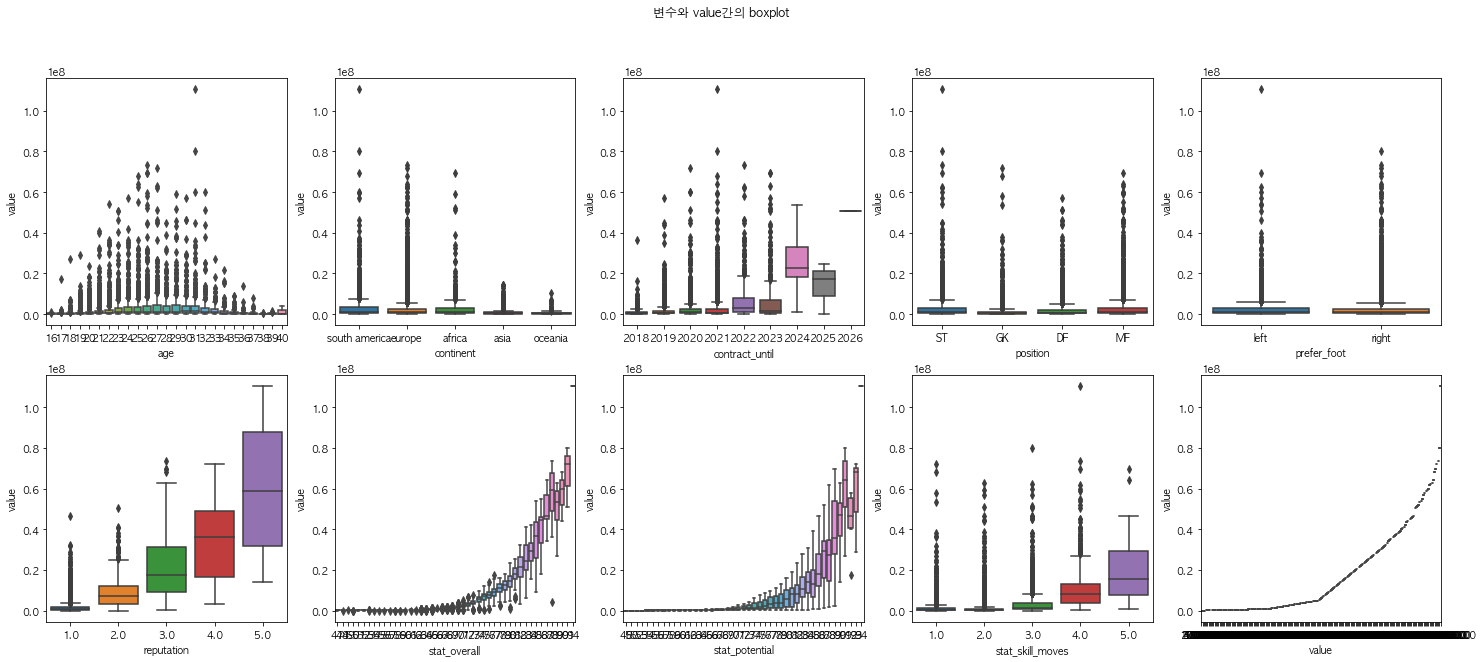

In [43]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.boxplot(x=train_copy[col[i]],y=train_copy['value'],ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('변수와 value간의 boxplot')    
plt.show()

* 이상치를 보유하고 있는 변수(메시) 제거 후 boxplot

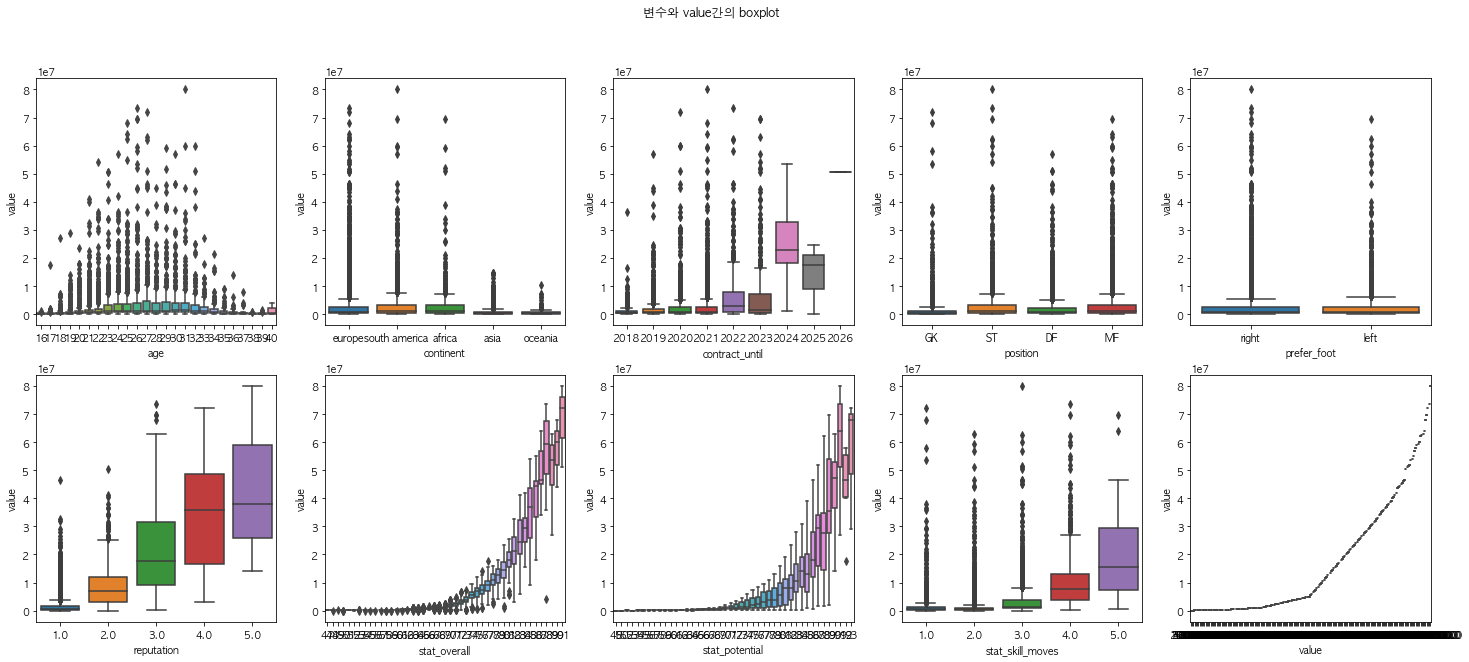

In [44]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.boxplot(x=train_copy[col[i]].iloc[1:],y=train_copy['value'].iloc[1:],ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('변수와 value간의 boxplot')    
plt.show()

* 이상치(메시) 제거

In [45]:
train_copy.iloc[1:]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
5,32,south america,2019,DF,right,3.0,90,90,2.0,44000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


* 학습용 데이터와 테스트 데이터의 변수 분포 확인

#### 수치형 자료의 분포

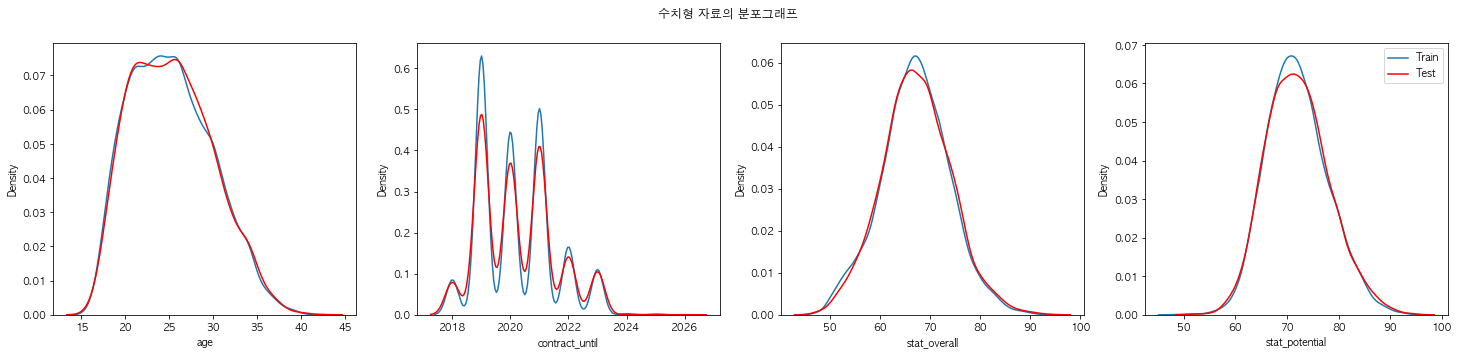

In [46]:
fig, ax = plt.subplots(1,4, figsize=(25,5))
ax = ax.flatten()
col = ['age','contract_until','stat_overall','stat_potential']
for i in range(len(col)):
    sns.distplot(train_copy[col[i]],kde=True,hist=False,hist_kws=({'alpha':1}),label='Train',ax=ax[i])
    sns.distplot(test_copy[col[i]],kde=True,hist=False,kde_kws=({'color':'red'}),label='Test',ax=ax[i])
    ax[i].set_xlabel(col[i])

plt.suptitle('수치형 자료의 분포그래프')    
plt.legend()
plt.show()

#### 범주형 자료의 비율

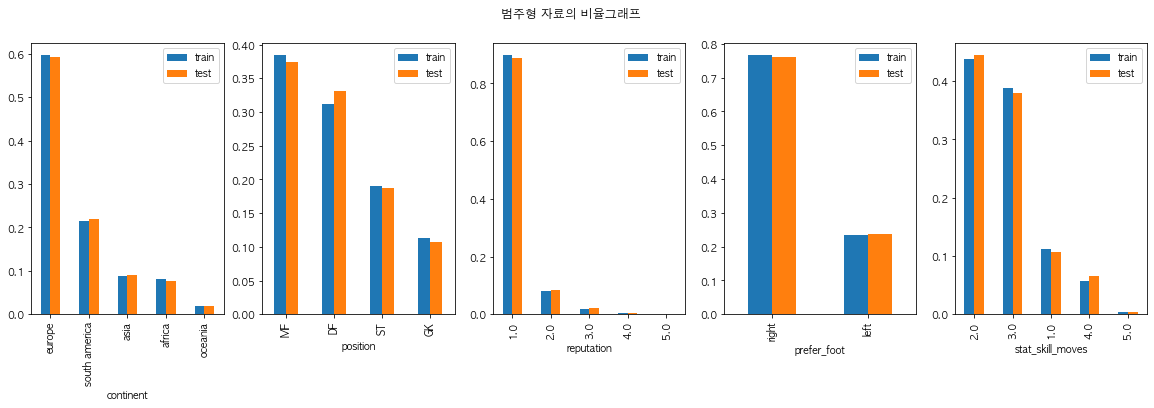

In [47]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax = ax.flatten()
col = ['continent','position','reputation','prefer_foot','stat_skill_moves']
for i in range(len(col)):

    train_continent = pd.DataFrame(train_copy[col[i]].value_counts() / len(train_copy))
    train_continent.rename(columns={col[i]:'train'},inplace=True)

    test_continent = pd.DataFrame(test_copy[col[i]].value_counts() / len(test_copy))
    test_continent.rename(columns={col[i]:'test'},inplace=True)

    pd.concat([train_continent,test_continent],axis=1).plot(kind='bar',ax=ax[i])
    ax[i].set_xlabel(col[i])  
plt.suptitle('범주형 자료의 비율그래프')
plt.show()

---

#### 상관계수

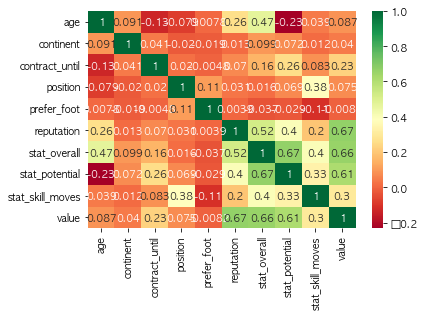

In [54]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

sns.heatmap(train_copy.corr(),cmap='RdYlGn',annot=True)
plt.show()

* 나이에 따른 stat_overall 비교

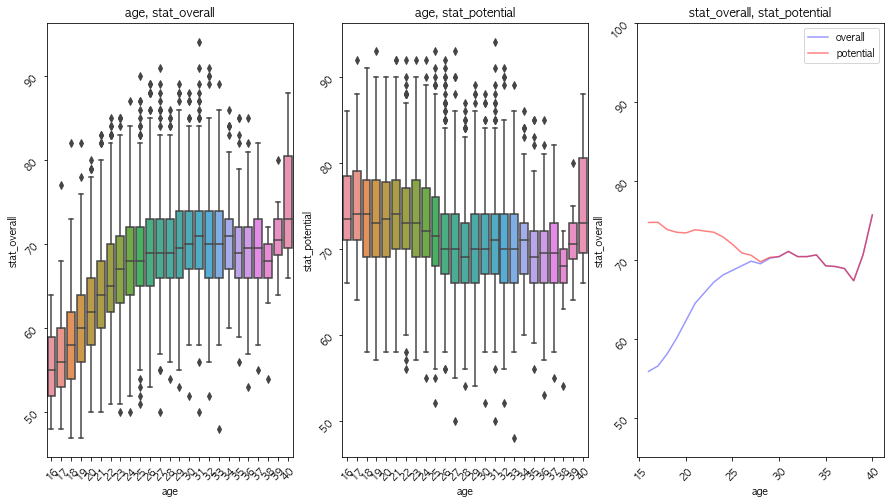

In [49]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax = ax.flatten()

sns.boxplot(train_copy['age'],train_copy['stat_overall'],ax=ax[0])
ax[0].set_title('age, stat_overall')
ax[0].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.boxplot(train_copy['age'],train_copy['stat_potential'],ax=ax[1])
ax[1].set_title('age, stat_potential')
ax[1].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.lineplot(train_copy['age'],train_copy['stat_overall'],ax=ax[2],label='overall',color='blue',ci=None,alpha=0.4)
sns.lineplot(train_copy['age'],train_copy['stat_potential'],ax=ax[2],label='potential',color='red',ci=None,alpha=0.5)
plt.ylim(45,100)
ax[2].set_title('stat_overall, stat_potential')
ax[2].tick_params(labelrotation=45)
plt.show()

In [50]:
age_stat_ratio = round(train_copy[train_copy['stat_overall']==train_copy['stat_potential']]['age'].value_counts() / train_copy[train_copy['age']>=25]['age'].value_counts(),3) * 100

print('stat_overall과 stat_potential이 같은 비율')
DataFrame(age_stat_ratio).rename(columns={'age':'ratio'}).T

stat_overall과 stat_potential이 같은 비율


,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
ratio,0.3,22.3,50.4,82.5,90.9,99.6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


---
#### value와의 상관계수

In [51]:
train_copy.drop('value',axis=1).corrwith(train['value']).sort_values()

prefer_foot        -0.008204
continent           0.039554
position            0.074980
age                 0.087319
contract_until      0.228638
stat_skill_moves    0.298500
stat_potential      0.611907
stat_overall        0.658444
reputation          0.665982
dtype: float64

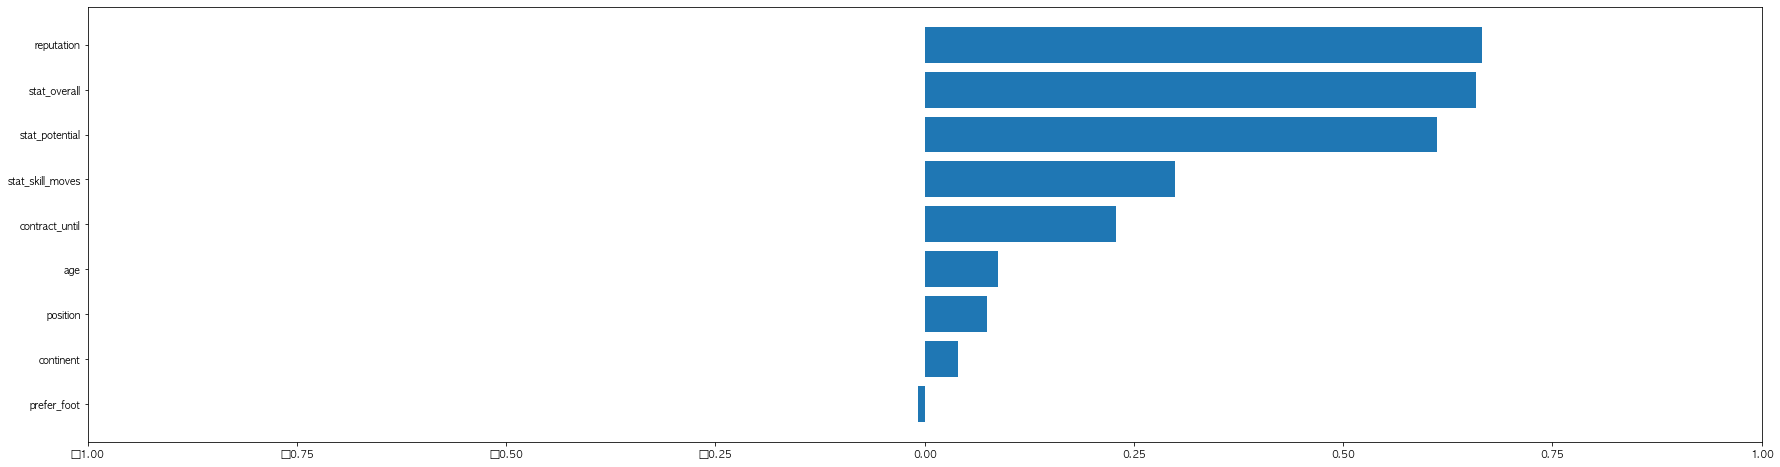

In [55]:
plt.figure(figsize=(30,8))
plt.barh(train_copy.drop('value',axis=1).corrwith(train['value']).sort_values().index,train_copy.drop('value',axis=1).corrwith(train['value']).sort_values())
plt.xlim(-1,1)
plt.show()

* reputatin, stat_overall, stat_potential의 상관 계수가 높다.